# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt 
import random
import re
from IPython.display import HTML

# Important

To change the resume location, update the resume location below and I recomend to use the pretrained parameter, as it take hours to train each model, and I didn't parallelize the code as i split the tokenised text into chunks of size 130 (128+2) and it was becoming quite complicated to parallize it, training it batch wise

In [2]:
resumes_location = "Dataset/UpdatedResumeDataSet.csv"
load_pretrained_model = False

## Beep Sound
This is just a small function i used to check if the training has been completed, please ignore this

In [3]:
from IPython.display import Audio
import numpy as np

def beep(frequency=1000, duration=0.2, rate=44100):
    t = np.linspace(0, duration, int(rate * duration), endpoint=False)
    wave = 0.5 * np.sin(2 * np.pi * frequency * t)
    return Audio(wave, rate=rate, autoplay=True)
# print("Hello")
beep()

# Loading the Dataset

In [4]:
df = pd.read_csv(resumes_location, engine='python', quotechar='"')
df = df[df["Category"]!= "Testing"].reset_index(drop=True)
df

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."
...,...,...
887,Blockchain,Hobbies â¢ Playing Chess â¢ Solving Rubik's ...
888,Blockchain,Skills Strong CS fundamentals and problem solv...
889,Blockchain,"KEY SKILLS: Programing languages: C, C++, Pyth..."
890,Blockchain,"SOFTWARE SKILLS: Languages: C, C++ & java Oper..."


# Data Analysis

In [5]:
df['Category'].value_counts()

Category
Java Developer               84
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Mechanical Engineer          40
Data Science                 40
Blockchain                   40
ETL Developer                40
Operations Manager           40
Sales                        40
Arts                         36
Database                     33
Electrical Engineering       30
Health and fitness           30
PMO                          30
DotNet Developer             28
Business Analyst             28
Automation Testing           26
Network Security Engineer    25
Civil Engineer               24
SAP Developer                24
Advocate                     20
Name: count, dtype: int64

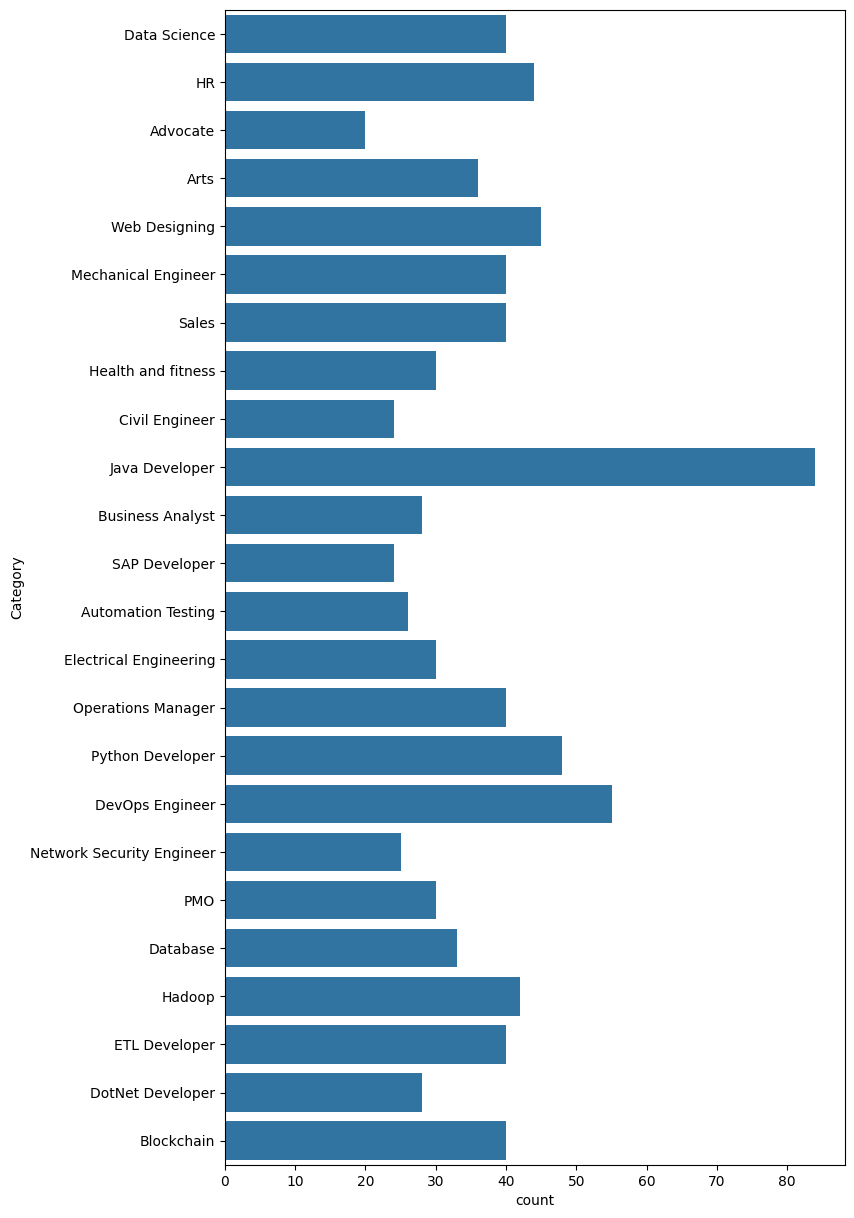

In [6]:
plt.figure(figsize=(8, 15))
sns.countplot(y='Category', data=df)
plt.show()

# Data Preprocessing

## Text Cleaning

In [7]:
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)         # remove HTML tags
    text = re.sub(r'http\S+', '', text)       # remove URLs
    text = re.sub(r'[\n\r\t]+',' ',text)         # remove "\n" and "\r"
    text = re.sub(r'[^a-zA-Z0-9., ]', '', text)
    text = re.sub(r'\s\s+',' ',text)         # remove extra space
    return text.lower().strip()

In [8]:
df['Resume'] = df['Resume'].apply(clean_text)
print(df["Category"][4])
print(df['Resume'][0])

Data Science
skills programming languages python pandas, numpy, scipy, scikitlearn, matplotlib, sql, java, javascriptjquery. machine learning regression, svm, nave bayes, knn, random forest, decision trees, boosting techniques, cluster analysis, word embedding, sentiment analysis, natural language processing, dimensionality reduction, topic modelling lda, nmf, pca neural nets. database visualizations mysql, sqlserver, cassandra, hbase, elasticsearch d3.js, dc.js, plotly, kibana, matplotlib, ggplot, tableau. others regular expression, html, css, angular 6, logstash, kafka, python flask, git, docker, computer vision open cv and understanding of deep learning.education details data science assurance associate data science assurance associate ernst young llp skill details javascript exprience 24 months jquery exprience 24 months python exprience 24 monthscompany details company ernst young llp description fraud investigations and dispute services assurance technology assisted review tar te

## Data Labeling

To label the data, i used some set of key words and counted the number of key words that were matching, and if the number of key words matching is atleast certain fraction of the total number of keywords in that job category then i labeled as shortlisted otherwise, that dude is not selected for the interview.

The following is the dictionary containing the keywords, and these were generated by chatGPT as i don't have the knowledge in most of the following fields.

### Keyword Dictionary 

In [9]:
job_skills = {
    "Java Developer": [
        "java", "spring", "hibernate", "j2ee", "servlets", "maven", "gradle", 
        "rest api", "oop", "multithreading", "jdbc", "eclipse", "intellij", 
        "junit", "design patterns", "tomcat", "json", "swagger", "log4j"
    ],
    "Web Designing": [
        "html", "css", "javascript", "responsive design", "bootstrap", "figma", 
        "adobe xd", "photoshop", "ui/ux", "sass", "web design", "wireframe", 
        "jquery", "media queries", "svg", "accessibility", "usability testing"
    ],
    "HR": [
        "recruitment", "onboarding", "payroll", "employee relations", "hrms", 
        "performance management", "interview scheduling", "training", 
        "talent acquisition", "benefits administration", "exit formalities", 
        "hrbp", "hr policy", "compliance", "grievance handling", "labor laws"
    ],
    "Hadoop": [
        "hadoop", "mapreduce", "hdfs", "pig", "hive", "oozie", "sqoop", "yarn", 
        "big data", "cloudera", "spark", "data lake", "parquet", "avro", "flume", 
        "zookeeper", "nosql", "impala"
    ],
    "Data Science": [
        "python", "machine learning", "pandas", "numpy", "scikit-learn", 
        "data analysis", "statistics", "deep learning", "data visualization", 
        "tensorflow", "keras", "matplotlib", "regression", "clustering", 
        "classification", "feature engineering", "nlp", "big data", "mlops", 
        "colab", "kaggle", "models", "cross-validation", "ai", "torch", "pytorch"
    ],
    "ETL Developer": [
        "etl", "informatica", "data pipeline", "data warehouse", "ssis", "sql", 
        "data migration", "data extraction", "oracle", "data stage", "etl testing", 
        "data transformation", "snowflake", "airflow", "dwh", "bi tools", 
        "data quality", "scheduling", "scripting", "reporting"
    ],
    "Operations Manager": [
        "operations", "supply chain", "logistics", "inventory", "management", 
        "process optimization", "vendor management", "erp", "strategic planning", 
        "team leadership", "lean", "six sigma", "kpi", "sla", "production planning", 
        "procurement", "warehouse", "resource allocation"
    ],
    "Database": [
        "sql", "mysql", "oracle", "postgresql", "database administration", "dbms", 
        "queries", "normalization", "indexing", "backup", "nosql", "mongodb", 
        "rdbms", "pl/sql", "replication", "sharding", "tuning", "schemas", "views"
    ],
    "Electrical Engineering": [
        "circuit", "electrical", "power systems", "embedded", "matlab", "pcb", 
        "electronics", "signal processing", "microcontroller", "simulink", 
        "transformer", "relay", "switchgear", "proteus", "arduino", "oscilloscope"
    ],
    "PMO": [
        "project management", "pmo", "scheduling", "risk management", "ms project", 
        "stakeholder", "project plan", "scrum", "agile", "budgeting", 
        "resource management", "milestone", "change management", "status report", 
        "kanban", "timeline"
    ],
    "DotNet Developer": [
        ".net", "c#", "asp.net", "mvc", "entity framework", "visual studio", "linq", 
        "sql server", "webforms", "razor", "api", "wpf", "windows forms", "xamarin", 
        "nuget", "iis", "web api", "dotnet core", "blazor"
    ],
    "Business Analyst": [
        "business analysis", "requirements gathering", "stakeholder", "user stories", 
        "brd", "frd", "sql", "process flow", "gap analysis", "agile", "scrum", 
        "jira", "as-is", "to-be", "mockups", "wireframe", "use case", 
        "data modeling", "rational rose"
    ],
    "Automation Testing": [
        "selenium", "test automation", "pytest", "java", "testng", "cypress", 
        "automation framework", "junit", "bdd", "robot framework", "jenkins", 
        "ci/cd", "postman", "soapui", "rest assured", "qa", "test scripts", 
        "selenium grid", "maven", "page object model"
    ],
    "Network Security Engineer": [
        "network security", "firewall", "vpn", "cybersecurity", "penetration testing", 
        "ids", "ips", "wireshark", "nmap", "siem", "tls", "ssl", "ccna", "ccnp", 
        "tcp/ip", "snort", "security audit", "threat hunting", "incident response"
    ],
    "Civil Engineer": [
        "autocad", "civil 3d", "construction", "site supervision", "structural", 
        "quantity survey", "estimation", "concrete", "staad pro", "project planning", 
        "revit", "bar bending", "dpr", "tendering", "autodesk", "soil testing"
    ],
    "Advocate": [
        "legal", "litigation", "drafting", "contracts", "legal research", "compliance", 
        "court", "pleading", "affidavit", "arbitration", "civil law", "criminal law", 
        "trademark", "intellectual property", "moot court", "notary", "bar council", 
        "legal notice", "case law"
    ],
    "Arts": [
        "painting", "drawing", "sketching", "sculpture", "fine arts", "exhibition",
        "portfolio", "art gallery", "visual arts", "illustration", "digital art",
        "design", "creative", "storyboarding", "concept art", "animation",
        "mixed media", "art history", "aesthetics", "color theory", "visual storytelling"
    ],
    "DevOps Engineer": [
        "devops", "ci/cd", "jenkins", "docker", "kubernetes", "aws", "terraform",
        "ansible", "linux", "bash", "scripting", "infrastructure as code", "iac",
        "monitoring", "grafana", "prometheus", "cloud", "gitlab", "github actions",
        "pipelines", "automation", "deployment", "logging", "helm", "containers", "cloudformation"
    ],
    "SAP Developer": [
        "sap", "abap", "sap hana", "sap fico", "sap mm", "sap sd", "module configuration",
        "bapi", "rfc", "sap workflow", "erp", "debugging", "sap basis", "idoc", "s/4hana",
        "customizing", "table maintenance", "sap netweaver", "module pool", "badi", "bapi", "sap scripts"
    ],
    "Sales": [
        "sales", "b2b", "b2c", "cold calling", "crm", "salesforce", "lead generation",
        "negotiation", "target achievement", "account management", "client retention",
        "pitching", "upselling", "cross-selling", "revenue generation", "business development",
        "sales target", "customer acquisition", "market research", "follow-up", "pipeline management"
    ],
    "Health and fitness": [
        "fitness", "health", "nutrition", "personal trainer", "workout", "exercise",
        "diet", "strength training", "aerobics", "yoga", "crossfit", "zumba",
        "wellness", "body transformation", "cardio", "gym trainer", "calisthenics",
        "weight loss", "fitness plan", "certified trainer", "fitness coach", "health education"
    ],
    "Python Developer": [
        "python", "flask", "django", "pandas", "numpy", "oop", "rest api",
        "scripting", "fastapi", "pytest", "data structures", "jupyter", "sqlalchemy",
        "tkinter", "matplotlib", "beautifulsoup", "requests", "pycharm", "unit testing",
        "api integration", "python automation", "decorators", "lambda functions", "list comprehension"
    ],
    "Mechanical Engineer": [
        "mechanical", "autocad", "solidworks", "mechanical design", "thermodynamics", "cad",
        "fea", "ansys", "hvac", "cam", "gd&t", "creo", "proe", "catia", "product design",
        "manufacturing", "tolerance analysis", "piping design", "iso 9001", "machine design",
        "mechatronics", "material science", "3d modeling", "statics", "dynamics"
    ],
    "Blockchain": [
        "blockchain", "ethereum", "smart contracts", "solidity", "web3", "cryptocurrency",
        "nft", "hyperledger", "consensus", "metamask", "truffle", "ganache", "dapp",
        "tokenomics", "defi", "staking", "hashing", "ipfs", "block explorer", "gas fee",
        "smart contract audit", "remix ide", "wallet", "private key", "evm", "zk-snark"
    ]
}


### Threshold and Labeling

The following code labels the dataset and the dictionary contains the threshold (the minimum fraction of total number of keywords) for each job category

In [10]:
category_thresholds = {
    "Java Developer": 20,
    "Python Developer": 20,
    "DotNet Developer": 30,
    "Web Designing": 40,
    "DevOps Engineer": 30,
    "Data Science": 20,
    "ETL Developer": 30,
    "Hadoop": 60,
    "Database": 30,
    "SAP Developer": 10,
    "HR": 5,
    "Operations Manager": 25,
    "PMO": 30,
    "Mechanical Engineer": 20,
    "Electrical Engineering": 30,
    "Civil Engineer": 30,
    "Automation Testing": 30,
    "Business Analyst": 30,
    "Network Security Engineer": 30,
    "Blockchain": 20,
    "Sales": 9,
    "Health and fitness": 15,
    "Arts": 10,
    "Advocate": 15
}



def label_resume(text, category, job_skills, category_thresholds):
    text = text.lower()
    skills = job_skills.get(category, [])
    match_count = sum(skill in text for skill in skills)
    threshold = len(skills) * category_thresholds[category]/100
    return 1 if match_count >= threshold else 0

# Apply labeling manually using a loop
labels = []
count = 0
for _, row in df.iterrows():
    label = label_resume(row['Resume'], row['Category'], job_skills, category_thresholds)
    count += label
    labels.append(label)
df['Shortlisted'] = labels
print("passed =", count)
print("failed =", len(labels) - count)

summary = df.groupby('Category')['Shortlisted'].agg(
    Shortlisted='sum',
    Total='count'
)
summary['Not Shortlisted'] = summary['Total'] - summary['Shortlisted']
summary['Percentage_passed'] = (summary['Shortlisted'] / summary['Total'] * 100).round(2)
summary = summary[['Shortlisted', 'Not Shortlisted', 'Shortlisted', 'Total', "Percentage_passed" ]]
# print(summary[summary["Percentage_passed"]<50])
HTML(summary.to_html())

passed = 424
failed = 468


,Shortlisted,Not Shortlisted,Shortlisted,Total,Percentage_passed
Category,,,,,
Advocate,8,12,8,20,40.00
Arts,12,24,12,36,33.33
Automation Testing,10,16,10,26,38.46
Blockchain,16,24,16,40,40.00
Business Analyst,12,16,12,28,42.86
Civil Engineer,8,16,8,24,33.33
Data Science,24,16,24,40,60.00
Database,15,18,15,33,45.45
DevOps Engineer,17,38,17,55,30.91


In [11]:
df

,Category,Resume,Shortlisted
0,Data Science,"skills programming languages python pandas, nu...",1
1,Data Science,education details may 2013 to may 2017 b.e uit...,1
2,Data Science,"areas of interest deep learning, control syste...",0
3,Data Science,skills r python sap hana tableau sap hana sql ...,1
4,Data Science,"education details mca ymcaust, faridabad, hary...",0
...,...,...,...
887,Blockchain,hobbies playing chess solving rubiks cube watc...,0
888,Blockchain,skills strong cs fundamentals and problem solv...,1
889,Blockchain,"key skills programing languages c, c, python, ...",0
890,Blockchain,"software skills languages c, c java operating ...",1


## Encoding Labels

In [12]:
label_encoder = LabelEncoder()
df['Category'] = label_encoder.fit_transform(df['Category'])
num_classes = len(label_encoder.classes_)
print(num_classes)

24


# Text Branch

## DataLoader

So the idea is to split the tokenized text into **multiple overlapping chunks** and pass it to the network, where the network will encode it and later we stack them together and do something. I haven't got this idea at first and i spent a lot of time tring to reduce the text, like removing the stop words, using a bigger encoder that takes larger number of tokens at a time, etc, etc and later i relaised that they weren't running in my laptop and then i switched by to bert, where I learned that bert require those stop words, yeah, so i kind of spent a lot of time in the wrong direction.

In [13]:
class TextBranchDataset(Dataset):
    def __init__(self, texts, labels, cls, tokenizer, window_size=128, stride=64, max_chunks=10):
        self.texts = texts
        self.labels = labels
        self.cls = cls
        self.tokenizer = tokenizer
        self.window_size = window_size
        self.stride = stride
        self.max_chunks = max_chunks

    def tokenize_and_chunk(self, text):
        tokens = self.tokenizer.encode(text, add_special_tokens=False)
        chunks = []
        if len(tokens) <= self.window_size :
            return [[self.tokenizer.cls_token_id] + tokens + [self.tokenizer.sep_token_id]]
        for i in range(0, len(tokens) - self.window_size + 1, self.stride):
            j = i + self.window_size if i + self.window_size < len(tokens) else len(tokens)
            chunk = tokens[i:j]
            chunk = [self.tokenizer.cls_token_id] + chunk + [self.tokenizer.sep_token_id]
            if(len(chunk)>130):
                print("Something went wrong")
            chunks.append(chunk)
            if len(chunks) >= self.max_chunks or j == len(tokens):
                break
        return chunks

    def __len__(self):
        return len(self.texts)
        
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        cls = self.cls[idx]
        chunks = self.tokenize_and_chunk(text)
        return chunks, label, cls

## Train, Test Split

Yeah, so i first split it into train, dev and test, and i ended up not using the dev at all, so i changed it back.

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
texts = df["Resume"].tolist()
labels = df["Shortlisted"].tolist()
cls = df["Category"].tolist()

# First split: 80% Train, 20% Temp (Dev+Test)
train_texts, test_texts, train_labels, test_labels, train_cls, test_cls = train_test_split(
    texts, labels, cls, test_size=0.2, random_state=42, stratify=labels
)

# Second split: 50% Dev, 50% Test -> 10% each
# dev_texts, test_texts, dev_labels, test_labels, dev_cls, test_cls = train_test_split(
#     temp_texts, temp_labels, temp_cls, test_size=0.5, random_state=42, stratify=temp_labels
# )

text_train_dataset = TextBranchDataset(train_texts, train_labels, train_cls, tokenizer)
# text_dev_dataset   = TextBranchDataset(dev_texts, dev_labels, dev_cls, tokenizer)
text_test_dataset  = TextBranchDataset(test_texts, test_labels, test_cls, tokenizer)

text_train_loader = DataLoader(text_train_dataset, batch_size=1, shuffle=True)
# text_dev_loader   = DataLoader(dev_dataset, batch_size=1)
text_test_loader  = DataLoader(text_test_dataset, batch_size=1)

## Classifying Model

After embeding each chunk using pretrained bert i stacked all the chunk embeddings together, which gives an output of shape `(n_chunks, seq_len, 768)` and then i transposed and passed it to a 1 dimensional Convolutional Layer giving an output of shape `(n_chunks, conv_out, seq_len)`, which learns things within each chunk and passed this thorugh an adaptive pooling layer which takes the maximum along each `seq_len` dimension and then i take the mean of all these chunks, which is fed into a feedforward neural network classifier.

The overall model outputs the probabilities for getting shortlisted in each job catogery.

In [15]:
class TextBranch(nn.Module):
    def __init__(self, num_classes, conv_out = 512):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.conv = nn.Conv1d(in_channels=768, out_channels= conv_out, kernel_size= 5, padding= 2)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
        )
        self.last_layer = nn.Linear(128, num_classes)
    def forward(self, input_chunks):  # input_chunks: list of [n_chunks x seq_len] tensors
        chunk_embeddings = []
        with torch.no_grad():  # freeze BERT
            for chunk in input_chunks:

                if not isinstance(chunk, torch.Tensor):
                    chunk = torch.tensor(chunk)  #.to(device)

                # chunk = torch.tensor(chunk).to(device)
                input_ids = chunk.unsqueeze(0).to(next(self.parameters()).device) # storing a chunk in the device
                attention_mask = torch.ones_like(input_ids)  # generating the attention masks for the chunk

                outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask) # passing the chunk to the bert model
                token_embeddings = outputs.last_hidden_state.squeeze(0)  # output of bert (seq_len, 768)
                chunk_embeddings.append(token_embeddings) # appending the output of bert to the chunk embeddings

        x = torch.stack(chunk_embeddings)          # (n_chunks, seq_len, 768), stacking the chunks
        x = x.permute(0, 2, 1)                     # (n_chunks, 768, seq_len)
        x = self.conv(x)                           # (n_chunks, conv_out, seq_len)
        x = F.relu(x)                              # (n_chunks, conv_out, seq_len)
        x = self.pool(x).squeeze(-1)               # (n_chunks, conv_out)
        x = x.mean(dim=0, keepdim=True)            # (1, conv_out)
        last = self.classifier(x)
        x = self.last_layer(last)
        output = F.sigmoid(x)
        return last, output.squeeze(0)

## Training

After every hundred examples, i printed out the number of hundreds in the progress column to check the pregress. I dont understand why i get this warning message not have, where input chunk is clearly of atmost 130 tokens

In [16]:
if not load_pretrained_model:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    text_model = TextBranch(num_classes).to(device)
    
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(text_model.parameters(), lr=2e-4)
    
    print(f"{'Progress':<10}{'Epoch':<12}{'Loss':<12}{'Accuracy':<12}{'Recall':<10}")
    
    # Training loop
    for epoch in range(10):
        predicted = []
        target = []
        count = 0
        text_model.train()
        total_loss = 0
        for batch in text_train_loader:
            if count %100 == 0:
                print(f"\r{count//100:>5}", end="")
            count += 1
            chunks, label, cls = batch  # since batch_size = 1
            # print(len(chunks))
            if(len(chunks) == 0):
                continue
                
            optimizer.zero_grad()
            _, output = text_model(chunks)  # shape: (num_classes,)
            label_tensor = torch.tensor(
                [float(label) if x == cls else 0.0 for x in range(num_classes)],
                device=device
            )
    
            loss = criterion(output, label_tensor)
            loss.backward()
            optimizer.step()
    
            total_loss += loss.item()
            pred = int(output.tolist()[cls] > 0.5)
            out = label
            # print("Predicted shape:", np.array(pred).shape, end = "\t")
            # print("Target shape:", np.array(out).shape)
            predicted.append(pred)
            target.append(out)
    
        acc = accuracy_score(target, predicted)
        recall = recall_score(target, predicted, average='macro')
        print(f"{epoch+1:>8}{total_loss:>14.4f}{acc*100:>13.2f}%{recall*100:>10.2f}%")
        
    beep()
else:
    text_model = TextBranch(num_classes)
    text_model.load_state_dict(torch.load('textbranch_weights.pth'))

Progress  Epoch       Loss        Accuracy    Recall    
    0

Token indices sequence length is longer than the specified maximum sequence length for this model (2565 > 512). Running this sequence through the model will result in indexing errors


    7       1       90.6709        52.73%     50.32%
    7       2       65.6365        52.88%     50.44%
    7       3       44.1077        60.17%     58.14%
    7       4       29.5190        71.11%     69.69%
    7       5       16.1302        83.17%     82.33%
    7       6        9.5697        90.60%     90.16%
    7       7        6.1790        94.11%     93.83%
    7       8        4.5705        95.79%     95.63%
    7       9        2.3667        98.04%     97.94%
    7      10        1.6456        99.02%     98.98%


The generated output for training the model, in case if you are using the pre trained model
| Progress | Epoch |   Loss   | Accuracy | Recall  |
|----------|--------|----------|----------|---------|
|    7     |   1    | 90.6709  |  52.73%  | 50.32% |
|    7     |   2    | 65.6365  |  52.88%  | 50.44% |
|    7     |   3    | 44.1077  |  60.17%  | 58.14% |
|    7     |   4    | 29.5190  |  71.11%  | 69.69% |
|    7     |   5    | 16.1302  |  83.17%  | 82.33% |
|    7     |   6    |  9.5697  |  90.60%  | 90.16% |
|    7     |   7    |  6.1790  |  94.11%  | 93.83% |
|    7     |   8    |  4.5705  |  95.79%  | 95.63% |
|    7     |   9    |  2.3667  |  98.04%  | 97.94% |
|    7     |  10    |  1.6456  |  99.02%  | 98.98% |


## Test resluts

In [17]:
text_model.eval()

predicted = []
targets = []

with torch.no_grad():
    for batch in text_test_loader:
        chunks, label, cls = batch  # since batch_size = 1

        _, output = text_model(chunks)
        output = output.tolist()
        # print(preds, "and", label)
        pred = int(output[cls] > 0.5)
        out = label           # assuming labels are one-hot

        predicted.append(pred)
        targets.append(out)

# Accuracy using sklearn
accuracy = accuracy_score(predicted, targets)
print(f"Validation Accuracy : {accuracy*100:.4f}%")

# Recall using sklearn
recall = recall_score(targets, predicted, average='macro')  # or 'weighted' if class imbalance
print(f"Validation Recall : {recall*100:.4f}%")


Validation Accuracy : 97.7654%
Validation Recall : 97.6471%


In [18]:
# Save only the model parameters (recommended)
torch.save(text_model.state_dict(), 'textbranch_weights.pth')


# Tabular Branch

## Profile Feature Extaction

After manually viewing some good number of training examples i came up with the following sections
- skills
- skill details
- education
- company details
- projects

And each section name has synomys so i used regex to get them too. The following are the synonmys that i considered
- **skills**: skills, technical skills, personal skills
- **skill details**: skill details, experience
- **education**: education
- **company details**: company details, company description, work experience, work experince, employment, industry
- **projects**: projects, project, technology assisted review, developed

For each section i search if there synonyms are present are not, if yes i add there position and the section name to my found list, later i sort this w.r.t to the positions and gather all the text between two tuples and ofcourse if the adjacent tuples are are of same section i skip the later tuple and keep going and gatering the text in between until i reach a tuple from different section or the end of my found list and then i add them to my new_sec dict, which i can return or append it to an exsisting dictionary. And also if i didn't find any such sections then it just an empty string

In this way i have divide the resume into different sections and storeed them as a pandas DataFrame.

In [19]:
sections = {
    "skills": [],
    "skill details": [],
    "education": [],
    "company details": [],
    "projects": []
    # "tools": []
}
def extract_relevant_sections(text, sections = None):
    found = []

    section_patterns = { 
        "skills": r"(skills|technical skills|personal skills)",
        "skill details": r"(skill details|experience)",
        "education": r"education",
        "company details": r"(company details|company description|work experience|work experince|employment|industry)",
        "projects": r"(projects|project|technology assisted review|developed)"
    }

    new_sec = {key: "" for key in section_patterns if key is not None}
    
    for section, pattern in section_patterns.items():
        matchs = re.finditer(pattern, text)
        if matchs is not None:
            for match in matchs:
                found.append((match.start(), section))

    found.sort()
    i =0
    while i < len(found):
        start = found[i][0]
        j= i+1
        while(j<len(found) and found[j][1]==found[i][1]):
            j += 1
        end = found[j][0] if j < len(found) else len(text)
        section_name = found[i][1]
        new_sec[section_name] += text[start:end]
        i =j
    if sections is None:
        return new_sec
    else:
        for key, value in new_sec.items():
            sections[key].append(value)
# x = extract_relevant_sections(df["Resume"][8])
# for key, value in x.items():
#     print(key, end= " :\n\n")
#     print(value, end= "\n\n\n")
            
df["Resume"].apply(lambda x: extract_relevant_sections(x, sections))

sdf = pd.DataFrame(sections)
sdf["Category"] = df["Category"]
sdf["Shortlisted"] = df["Shortlisted"]
cols = ['Category'] + [col for col in sdf.columns if col != 'Category']
sdf = sdf[cols]
# HTML(sdf.to_html())


# resume = df['Resume'][0]
# extract_relevant_sections(resume)

# for key, value in sections.items():
#     print(key,":", end = "\n\n")
#     print(value, end="\n\n\n")
# print("\n\n=================================================================================================================================================================\n\n\n")
# print(resume)

## Encoding Labels

In [20]:
label_encoder = LabelEncoder()
sdf['Category'] = label_encoder.fit_transform(sdf['Category'])
num_classes = len(label_encoder.classes_)
print(num_classes)

24


## DataLoader

Similar to the previous branch, i tokenised the text in each section and broke them into small chunks and returned it as a dictionary

In [21]:
sections = {
    "skills": [],
    "skill details": [],
    "education": [],
    "company details": [],
    "projects": []
    # "tools": []
}
class TabularBranchDataset(Dataset):
    def __init__(self, cv, labels, cls, tokenizer, window_size=128, stride=64, max_chunks=10):
        self.cv = cv
        self.labels = labels
        self.cls = cls
        self.tokenizer = tokenizer
        self.window_size = window_size
        self.stride = stride
        self.max_chunks = max_chunks

    def tokenize_and_chunk(self, text):
        tokens = self.tokenizer.encode(text, add_special_tokens=False)
        chunks = []
        if len(tokens) <= self.window_size :
            return [[self.tokenizer.cls_token_id] + tokens + [self.tokenizer.sep_token_id]]
        for i in range(0, len(tokens) - self.window_size + 1, self.stride):
            j = i + self.window_size if i + self.window_size < len(tokens) else len(tokens)
            chunk = tokens[i:j]
            chunk = [self.tokenizer.cls_token_id] + chunk + [self.tokenizer.sep_token_id]
            if(len(chunk)>130):
                print("Something went wrong")
            chunks.append(chunk)
            if len(chunks) >= self.max_chunks or j == len(tokens):
                break
        return chunks

    def __len__(self):
        return len(self.cv)
        
    def __getitem__(self, idx):
        resume = self.cv[idx]
        label = self.labels[idx]
        cls = self.cls[idx]
        chunks = {key : self.tokenize_and_chunk(text) for key, text in resume.items()}
        return chunks, label, cls

## Train, Test Split

In [22]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
cv = sdf[["skills", "skill details", "education", "company details", "projects"]].to_dict(orient='records')
labels = sdf["Shortlisted"].tolist()
cls = sdf["Category"].tolist()

# First split: 80% Train, 20% Temp (Dev+Test)
train_cv, test_cv, train_labels, test_labels, train_cls, test_cls = train_test_split(
    cv, labels, cls, test_size=0.2, random_state=42, stratify=labels
)

# Second split: 50% Dev, 50% Test -> 10% each
# dev_cv, test_cv, dev_labels, test_labels, dev_cls, test_cls = train_test_split(
#     temp_cv, temp_labels, temp_cls, test_size=0.5, random_state=42, stratify=temp_labels
# )

cv_train_dataset = TabularBranchDataset(train_cv, train_labels, train_cls, tokenizer)
# cv_dev_dataset   = TextBranchDataset(dev_cv, dev_labels, dev_cls, tokenizer)
cv_test_dataset  = TabularBranchDataset(test_cv, test_labels, test_cls, tokenizer)

cv_train_loader = DataLoader(cv_train_dataset, batch_size=1, shuffle=True)
# cv_dev_loader   = DataLoader(dev_dataset, batch_size=1)
cv_test_loader  = DataLoader(cv_test_dataset, batch_size=1)

## Classifying Model

The Model performs similar to the TextBranch Model, where we first get the embeddings of each chunk `(seq_len, 768)` using the pre trained bert and then stack all of the chunks and take the transpose `(n_chunks, 768, seq_len)` and pass it through a 1 dimensional Convolutional Layer `(n_chunks, conv_out, seq_len)` followed by an Adaptive pooling layer `(n_chunks, conv_out)` and then i take the mean across all the chunks `(1, conv_out)` and finally get some sort of encoding of text in each section, which i then stack them up and transpose `( conv_out, 5 sections)` and pass it thorough a 1 dimensional Convolutional layer with a filter of size `5` without and any padding and transpose it to get an output of size `(1, conv_out)`, which is then fed into a feedward network.

This model finally outputs probability of being short listed for each job category.

In [23]:
class TabularBranch(nn.Module):
    def __init__(self, num_classes, conv_out = 512):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.conv1 = nn.Conv1d(in_channels=768, out_channels= 512, kernel_size= 5, padding= 2)
        self.conv2 = nn.Conv1d(in_channels=512, out_channels= 512, kernel_size= 5)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
        )
        self.last_layer = nn.Linear(128, num_classes)
    def forward(self, input_dict):  # input_chunks: list of [n_chunks x seq_len] tensors
        tabular_encoding = []
        for key in input_dict:
            input_chunks = input_dict[key]
            chunk_embeddings = []
            with torch.no_grad():  # freeze BERT
                for chunk in input_chunks:
    
                    if not isinstance(chunk, torch.Tensor):
                        chunk = torch.tensor(chunk)  #.to(device)
    
                    # chunk = torch.tensor(chunk).to(device)
                    input_ids = chunk.unsqueeze(0).to(next(self.parameters()).device) # storing a chunk in the device
                    attention_mask = torch.ones_like(input_ids)  # generating the attention masks for the chunk
    
                    outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask) # passing the chunk to the bert model
                    token_embeddings = outputs.last_hidden_state.squeeze(0)  # output of bert (seq_len, 768)
                    chunk_embeddings.append(token_embeddings) # appending the output of bert to the chunk embeddings

            x = torch.stack(chunk_embeddings)          # (n_chunks, seq_len, 768), stacking the chunks
            x = x.permute(0, 2, 1)                     # (n_chunks, 768, seq_len)
            x = self.conv1(x)                           # (n_chunks, conv_out, seq_len)
            x = F.relu(x)                              # (n_chunks, conv_out, seq_len)
            x = self.pool(x).squeeze(-1)               # (n_chunks, conv_out)
            x = x.mean(dim=0, keepdim=True)            # (1, conv_out)
            tabular_encoding.append(x.squeeze())
        x = torch.stack(tabular_encoding).permute(1, 0)    # (conv_out, 5)
        x = self.conv2(x).permute(1, 0)                    # (1, conv_out)
        last = self.classifier(x)
        x = self.last_layer(last)
        output = F.sigmoid(x)
        return last, output.squeeze(0)

## Training

In [24]:
if not load_pretrained_model:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    tabular_model = TabularBranch(num_classes).to(device)
    
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(tabular_model.parameters(), lr=2e-4)
    
    print(f"{'Progress':<10}{'Epoch':<12}{'Loss':<12}{'Accuracy':<12}{'Recall':<10}")
    
    # Training loop
    for epoch in range(10):
        predicted = []
        target = []
        count = 0
        tabular_model.train()
        total_loss = 0
        for batch in cv_train_loader:
            if count %100 == 0:
                print(f"\r{count//100:>5}", end="")
            count += 1
            chunks_dict, label, cls = batch  # since batch_size = 1
            # print(len(chunks))
            if(len(chunks_dict) == 0):
                continue
                
            optimizer.zero_grad()
            _, output = tabular_model(chunks_dict)  # shape: (num_classes,)
            label_tensor = torch.tensor(
                [float(label) if x == cls else 0.0 for x in range(num_classes)],
                device=device
            )
    
            loss = criterion(output, label_tensor)
            loss.backward()
            optimizer.step()
    
            total_loss += loss.item()
            pred = int(output.tolist()[cls] > 0.5)
            out = label
            # print("Predicted shape:", np.array(pred).shape, end = "\t")
            # print("Target shape:", np.array(out).shape)
            predicted.append(pred)
            target.append(out)
    
        acc = accuracy_score(target, predicted)
        recall = recall_score(target, predicted, average='macro')
        print(f"{epoch+1:>8}{total_loss:>14.4f}{acc*100:>13.2f}%{recall*100:>10.2f}%")
        
    beep()
else:
    tabular_model = TextBranch(num_classes)
    tabular_model.load_state_dict(torch.load('tabularbranch_weights.pth'))

Progress  Epoch       Loss        Accuracy    Recall    
    0

Token indices sequence length is longer than the specified maximum sequence length for this model (657 > 512). Running this sequence through the model will result in indexing errors


    7       1       96.1775        52.59%     50.19%
    7       2       67.1994        52.73%     50.29%
    7       3       40.4548        64.80%     63.02%
    7       4       19.4821        81.49%     80.56%
    7       5       10.4038        89.90%     89.39%
    7       6        5.3001        95.23%     95.00%
    7       7        2.4122        98.18%     98.08%
    7       8        3.1731        97.62%     97.52%
    7       9        2.9334        97.62%     97.51%
    7      10        1.3894        99.30%     99.26%


The generated output for training the model, in case if you are using the pretrained model
| Progress | Epoch |   Loss   | Accuracy | Recall  |
|----------|--------|----------|----------|---------|
|    7     |   1    | 96.1775  |  52.59%  | 50.19% |
|    7     |   2    | 67.1994  |  52.73%  | 50.29% |
|    7     |   3    | 40.4548  |  64.80%  | 63.02% |
|    7     |   4    | 19.4821  |  81.49%  | 80.56% |
|    7     |   5    | 10.4038  |  89.90%  | 89.39% |
|    7     |   6    |  5.3001  |  95.23%  | 95.00% |
|    7     |   7    |  2.4122  |  98.18%  | 98.08% |
|    7     |   8    |  3.1731  |  97.62%  | 97.52% |
|    7     |   9    |  2.9334  |  97.62%  | 97.51% |
|    7     |  10    |  1.3894  |  99.30%  | 99.26% |


## Testing

In [25]:
tabular_model.eval()

predicted = []
targets = []

with torch.no_grad():
    for batch in cv_test_loader:
        chunks_dict, label, cls = batch  # since batch_size = 1

        _, output = tabular_model(chunks_dict)
        output = output.tolist()
        # print(preds, "and", label)
        pred = int(output[cls] > 0.5)
        out = label           # assuming labels are one-hot

        predicted.append(pred)
        targets.append(out)

# Accuracy using sklearn
accuracy = accuracy_score(predicted, targets)
print(f"Validation Accuracy : {accuracy*100:.4f}%")

# Recall using sklearn
recall = recall_score(targets, predicted, average='macro')  # or 'weighted' if class imbalance
print(f"Validation Recall : {recall*100:.4f}%")


Validation Accuracy : 95.5307%
Validation Recall : 95.4068%


In [26]:
# Save only the model parameters (recommended)
torch.save(tabular_model.state_dict(), 'tabularbranch_weights.pth')

# Fusion Model

## DataLoader

In [27]:
class FusionDataset(Dataset):
    def __init__(self, texts, cv, labels, cls, tokenizer, window_size=128, stride=64, max_chunks=10):
        self.cv = cv
        self.texts = texts
        self.labels = labels
        self.cls = cls
        self.tokenizer = tokenizer
        self.window_size = window_size
        self.stride = stride
        self.max_chunks = max_chunks

    def tokenize_and_chunk(self, text):
        tokens = self.tokenizer.encode(text, add_special_tokens=False)
        chunks = []
        if len(tokens) <= self.window_size :
            return [[self.tokenizer.cls_token_id] + tokens + [self.tokenizer.sep_token_id]]
        for i in range(0, len(tokens) - self.window_size + 1, self.stride):
            j = i + self.window_size if i + self.window_size < len(tokens) else len(tokens)
            chunk = tokens[i:j]
            chunk = [self.tokenizer.cls_token_id] + chunk + [self.tokenizer.sep_token_id]
            if(len(chunk)>130):
                print("Something went wrong")
            chunks.append(chunk)
            if len(chunks) >= self.max_chunks or j == len(tokens):
                break
        return chunks

    def __len__(self):
        return len(self.texts)
        
    def __getitem__(self, idx):
        text = self.texts[idx]
        resume = self.cv[idx]
        label = self.labels[idx]
        cls = self.cls[idx]
        text_chunks = self.tokenize_and_chunk(text)
        tabular_chunks = {key : self.tokenize_and_chunk(txt) for key, txt in resume.items()}
        return text_chunks, tabular_chunks, label, cls

## Train, Test Split

In [28]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
cv = sdf[["skills", "skill details", "education", "company details", "projects"]].to_dict(orient='records')
texts = df["Resume"].tolist()
labels = sdf["Shortlisted"].tolist()
cls = sdf["Category"].tolist()

# First split: 80% Train, 20% Temp (Dev+Test)
train_text, test_text, train_cv, test_cv, train_labels, test_labels, train_cls, test_cls = train_test_split(
   texts, cv, labels, cls, test_size=0.2, random_state=42, stratify=labels
)

# Second split: 50% Dev, 50% Test -> 10% each
# dev_cv, test_cv, dev_labels, test_labels, dev_cls, test_cls = train_test_split(
#     temp_cv, temp_labels, temp_cls, test_size=0.5, random_state=42, stratify=temp_labels
# )

fusion_train_dataset = FusionDataset(train_text, train_cv, train_labels, train_cls, tokenizer)
# cv_dev_dataset   = TextBranchDataset(dev_cv, dev_labels, dev_cls, tokenizer)
fusion_test_dataset  = FusionDataset(test_text, test_cv, test_labels, test_cls, tokenizer)

fusion_train_loader = DataLoader(fusion_train_dataset, batch_size=1, shuffle=True)
# cv_dev_loader   = DataLoader(dev_dataset, batch_size=1)
fusion_test_loader  = DataLoader(fusion_test_dataset, batch_size=1)

In [29]:
class FusionModel(nn.Module):
    def __init__(self, tabular_dim=128, text_dim=128, num_classes=24):
        super().__init__()
        self.fc1 = nn.Linear(tabular_dim + text_dim, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, text_features, tabular_features):
        x = torch.cat([text_features, tabular_features], dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x.squeeze(0)

## Training

In [30]:
if not load_pretrained_model:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    text_model = TextBranch(num_classes = num_classes).to(device)
    tabular_model = TabularBranch(num_classes = num_classes).to(device)
    fusion_model = FusionModel(num_classes = num_classes).to(device)
    
    criterion = nn.BCELoss()
    parameters = list(text_model.parameters()) + list(tabular_model.parameters()) + list(fusion_model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=2e-4)
    
    print(f"{'Progress':<10}{'Epoch':<12}{'Loss':<12}{'Accuracy':<12}{'Recall':<10}")
    
    # Training loop
    for epoch in range(10):
        predicted = []
        target = []
        count = 0
        tabular_model.train()
        total_loss = 0
        for batch in fusion_train_loader:
            if count %100 == 0:
                print(f"\r{count//100:>5}", end="")
            count += 1
            
            text_chunks, tabular_chunks, label, cls = batch  # since batch_size = 1
            # print(len(chunks))
            if(len(text_chunks) == 0 or len(tabular_chunks) == 0 ):
                continue
                
            optimizer.zero_grad()
            text_output, _ = text_model(text_chunks)  # shape: (num_classes,)
            tabular_output, _ = tabular_model(tabular_chunks)  # shape: (num_classes,)
            output = fusion_model(text_output, tabular_output)
            label_tensor = torch.tensor(
                [float(label) if x == cls else 0.0 for x in range(num_classes)],
                device=device
            )
    
            loss = criterion(output, label_tensor)
            loss.backward()
            optimizer.step()
    
            total_loss += loss.item()
            pred = int(output.tolist()[cls] > 0.5)
            out = label
            # print("Predicted shape:", np.array(pred).shape, end = "\t")
            # print("Target shape:", np.array(out).shape)
            predicted.append(pred)
            target.append(out)
    
        acc = accuracy_score(target, predicted)
        recall = recall_score(target, predicted, average='macro')
        print(f"{epoch+1:>8}{total_loss:>14.4f}{acc*100:>13.2f}%{recall*100:>10.2f}%")
        
    beep()
else:
    text_model = TextBranch(num_classes = num_classes).to(device)
    text_model.load_state_dict(torch.load('fused_text_weights.pth'))
    tabular_model = TabularBranch(num_classes = num_classes).to(device)
    tabular_model.load_state_dict(torch.load('fused_tabular_weights.pth'))
    fusion_model = TextBranch(num_classes)
    fusion_model.load_state_dict(torch.load('fusion_weights.pth'))

Progress  Epoch       Loss        Accuracy    Recall    
    0

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors


    7       1       94.6158        52.73%     50.32%
    7       2       67.9045        52.45%     50.00%
    7       3       53.0094        57.36%     55.18%
    7       4       33.4612        69.85%     68.29%
    7       5       18.8919        80.36%     79.36%
    7       6       12.9753        87.38%     86.73%
    7       7        8.4672        92.43%     92.05%
    7       8        5.5174        95.37%     95.13%
    7       9        4.0545        96.91%     96.76%
    7      10        5.4146        95.93%     95.78%


The generated output for training the model, in case if you are using the pretrained model
| Progress | Epoch |   Loss   | Accuracy | Recall  |
|----------|--------|----------|----------|---------|
|    7     |   1    | 94.6158  |  52.73%  | 50.32% |
|    7     |   2    | 67.9045  |  52.45%  | 50.00% |
|    7     |   3    | 53.0094  |  57.36%  | 55.18% |
|    7     |   4    | 33.4612  |  69.85%  | 68.29% |
|    7     |   5    | 18.8919  |  80.36%  | 79.36% |
|    7     |   6    | 12.9753  |  87.38%  | 86.73% |
|    7     |   7    |  8.4672  |  92.43%  | 92.05% |
|    7     |   8    |  5.5174  |  95.37%  | 95.13% |
|    7     |   9    |  4.0545  |  96.91%  | 96.76% |
|    7     |  10    |  5.4146  |  95.93%  | 95.78% |

## Testing

In [31]:
text_model.eval()
tabular_model.eval()
fusion_model.eval()

predicted = []
targets = []

with torch.no_grad():
    for batch in fusion_test_loader:
        text_chunks, tabular_chunks, label, cls = batch

        text_output, _ = text_model(text_chunks)
        tabular_output, _ = tabular_model(tabular_chunks)  # shape: (num_classes,)
        output = fusion_model(text_output, tabular_output).tolist()
        # print(preds, "and", label)
        pred = int(output[cls] > 0.5)
        out = label           # assuming labels are one-hot

        predicted.append(pred)
        targets.append(out)

# Accuracy using sklearn
accuracy = accuracy_score(predicted, targets)
print(f"Validation Accuracy : {accuracy*100:.4f}%")

# Recall using sklearn
recall = recall_score(targets, predicted, average='macro')  # or 'weighted' if class imbalance
print(f"Validation Recall : {recall*100:.4f}%")

Validation Accuracy : 97.7654%
Validation Recall : 97.6471%


In [34]:
# Save only the model parameters (recommended)
torch.save(text_model.state_dict(), 'fused_text_weights.pth')
torch.save(tabular_model.state_dict(), 'fused_tabular_weights.pth')
torch.save(fusion_model.state_dict(), 'fusion_weights.pth')